In [4]:
#IMPORT Statements

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest

from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

import xgboost as xgb

sns.set_style('darkgrid')

%matplotlib inline


In [3]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 7.0 MB/s eta 0:00:00
     ------------------------------------- 420.6/420.6 kB 13.2 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 126.5/126.5 kB ? eta 0:00:00
     ------------------------------------- 440.7/440.7 kB 28.7 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 18.7 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 16.3 MB/s eta 0:00:00
     ---------------------------------


[notice] A new release of pip available: 22.3.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Function to plot model loss
def plot_model_loss(hist, title):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

# Function to plot model accuracy
def plot_model_accuracy(hist, title):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    

In [6]:
# Load the dataset
data = pd.read_csv('diabetes_prediction_dataset.csv')
data.head()


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
# Generate dataset summary statistics
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [8]:
# Summary of DataFrame structure, types
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


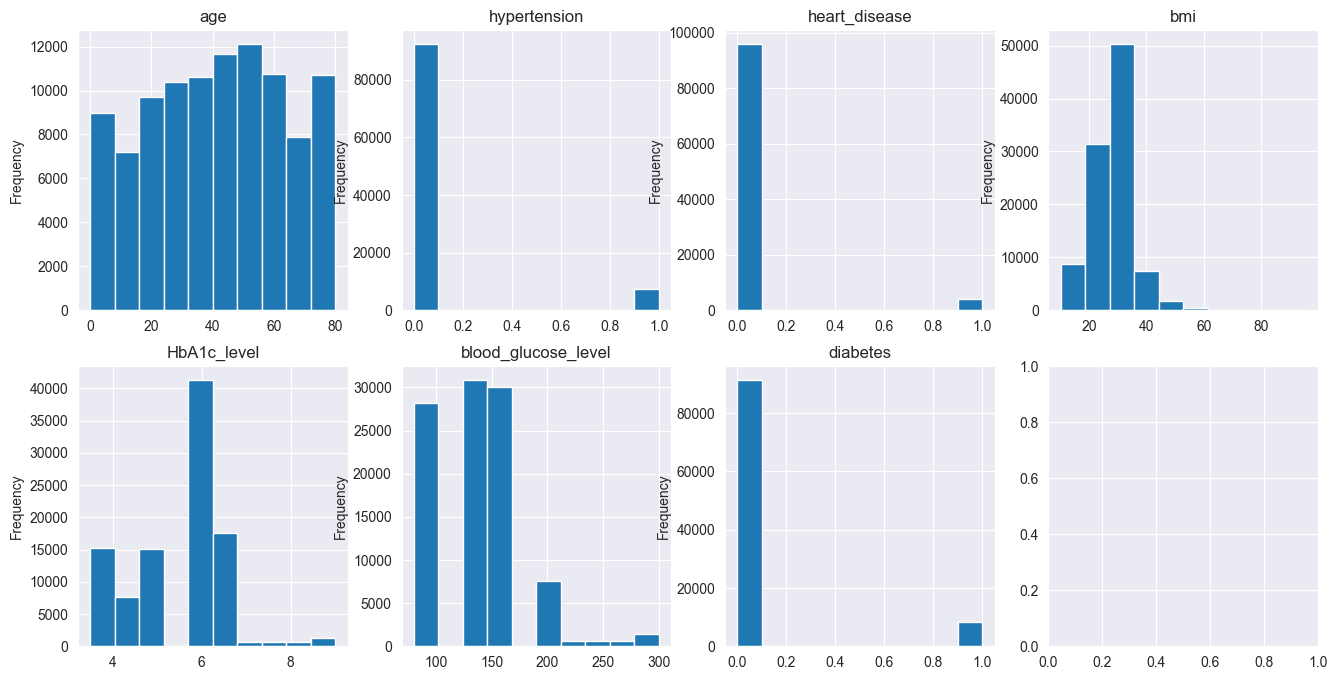

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

numeric_columns = data.select_dtypes(include='number').columns.tolist()

for idx, column in enumerate(numeric_columns):
    row_idx = idx // 4
    col_idx = idx % 4
    data[column].plot(kind='hist', ax=axes[row_idx, col_idx], title=column)

plt.show()



<AxesSubplot: >

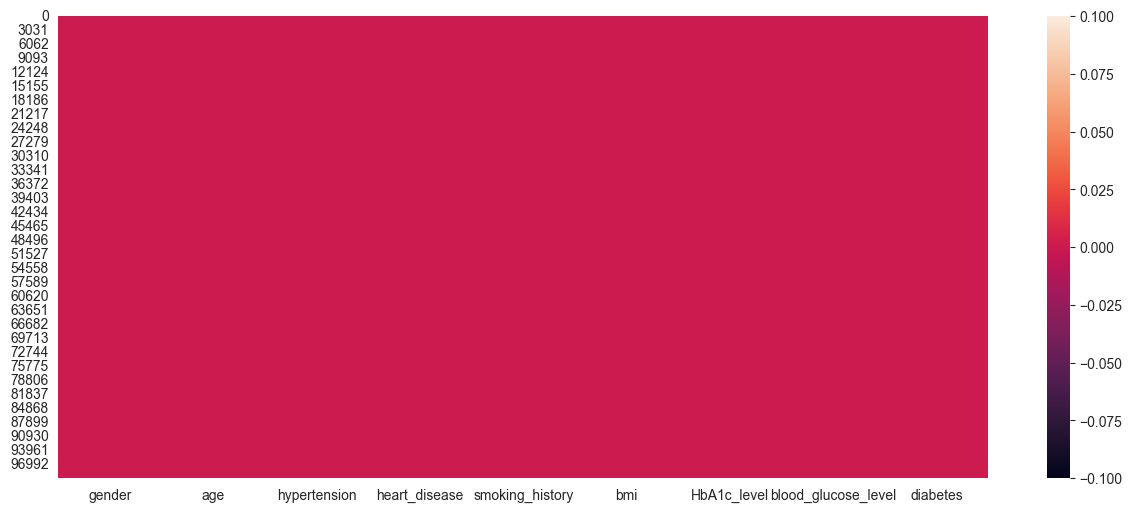

In [8]:
# Null HeatMap
plt.figure(figsize=(15,6))
sns.heatmap(data.isna())


<AxesSubplot: xlabel='diabetes', ylabel='count'>

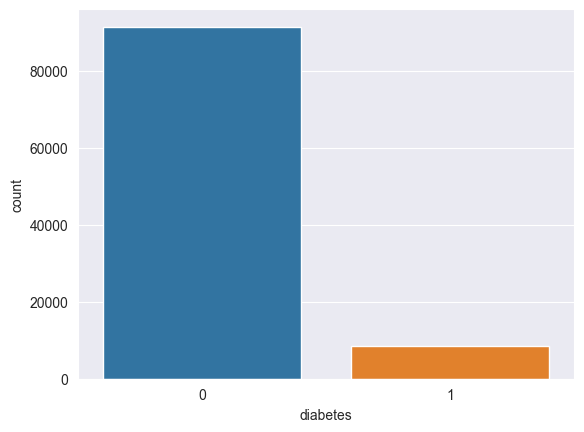

In [9]:
# Small EDA
sns.countplot(x=data['diabetes'])


In [10]:
# Preprocessing
data['gender'] = data['gender'].astype('category').cat.codes
data['smoking_history'] = data['smoking_history'].astype('category').cat.codes

# Regression: Predict blood_glucose_level
X_reg = data.drop(['blood_glucose_level'], axis=1)
y_reg = data['blood_glucose_level']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)

print(f"Regression: Mean squared error: {mean_squared_error(y_test_reg, y_pred_reg)}")
print(f"Regression: R2 score: {r2_score(y_test_reg, y_pred_reg)}")


Regression: Mean squared error: 1360.4133929146158
Regression: R2 score: 0.17494754876764274


In [11]:
# Anomaly Detection: Detect outliers in the dataset
anomaly_detector = IsolationForest(contamination=0.05, random_state=42)
anomaly_detector.fit(data)
outliers = anomaly_detector.predict(data)

# Print the number of outliers detected
print(f"Anomaly Detection: Number of outliers detected: {np.count_nonzero(outliers == -1)}")


C:\Users\Bhavitha Redrouthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Anomaly Detection: Number of outliers detected: 5000


In [12]:
# Encode categorical variables
le_gender = LabelEncoder()
le_smoking = LabelEncoder()
data['gender'] = le_gender.fit_transform(data['gender'])
data['smoking_history'] = le_smoking.fit_transform(data['smoking_history'])

# Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
data[numerical_features] = scaler.fit_transform(data[numerical_features])


In [13]:
# Split the dataset
X = data.drop('diabetes', axis=1)
y = data['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Splits validation data further
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Prints shapes of dataset splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(50000, 8) (50000, 8) (50000,) (50000,)


# SK-Learn Models

# Logistic Regression

In [14]:
# Classification: Predict diabetes using Logistic Regression
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train, y_train)
y_pred_logistic = logistic_classifier.predict(X_test)

print("Classification: Logistic Regression")
print(classification_report(y_test, y_pred_logistic))


Classification: Logistic Regression
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     45741
           1       0.88      0.61      0.72      4259

    accuracy                           0.96     50000
   macro avg       0.92      0.80      0.85     50000
weighted avg       0.96      0.96      0.96     50000



# Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rf_classifier = RandomForestClassifier()

param_grid = {   'n_estimators' : [50, 100, 150, ],
    
                'criterion': ['entropy','gini'],
            
               'max_depth': [3,4,5,],
              
              }

In [16]:
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1, verbose=1)

In [17]:
grid_search_rf = grid_search_rf.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


In [18]:
print(grid_search_rf.best_score_)

0.9720599999999999


In [19]:
print(grid_search_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 50}


In [20]:
y_pred = grid_search_rf.predict(X_test) 
y_pred[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [21]:
from sklearn.metrics import accuracy_score
accu_rf = accuracy_score(y_pred,y_test)

print('Test Accuracy Random Forest Classifer :', accu_rf)

Test Accuracy Random Forest Classifer : 0.97168


# Non SK-Learn Model

# Neural Network Model

In [15]:
# Define the Neural Network Model
model1 = Sequential()
model1.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model1.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2129 - accuracy: 0.9229 - val_loss: 0.1286 - val_accuracy: 0.9554
Epoch 2/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1201 - accuracy: 0.9594 - val_loss: 0.1151 - val_accuracy: 0.9577
Epoch 3/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1169 - accuracy: 0.9606 - val_loss: 0.1162 - val_accuracy: 0.9593
Epoch 4/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1164 - accuracy: 0.9605 - val_loss: 0.1154 - val_accuracy: 0.9587
Epoch 5/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1160 - accuracy: 0.9606 - val_loss: 0.1154 - val_accuracy: 0.9581
Epoch 6/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1158 - accuracy: 0.9609 - val_loss: 0.1132 - val_accuracy: 0.9587
Epoch 7/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1151 - accuracy: 0.9603 - val_loss: 0.1165 - val_accuracy:

In [16]:
# Evaluate the model
y_pred1 = (model1.predict(X_test) > 0.5).astype('int32')
accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Model 1 Accuracy: {accuracy1}")


1563/1563 [==============================] - 2s 940us/step
Model 1 Accuracy: 0.9618


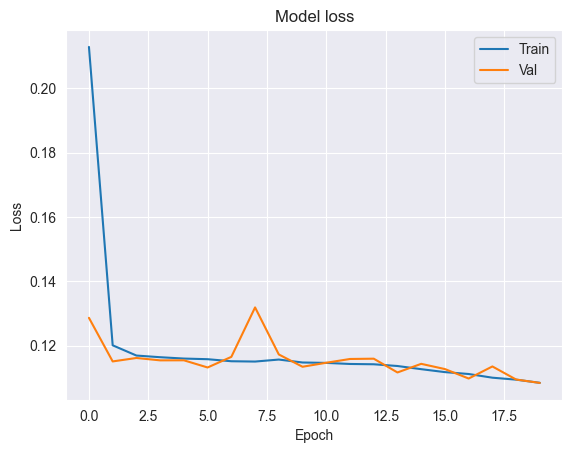

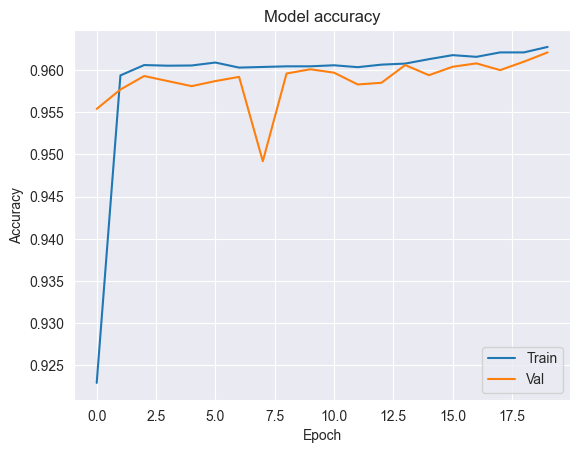

In [17]:
# Call the plot functions
plot_model_loss(hist, 'Model loss')

plot_model_accuracy(hist, 'Model accuracy')


In [18]:
# Print the summary
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

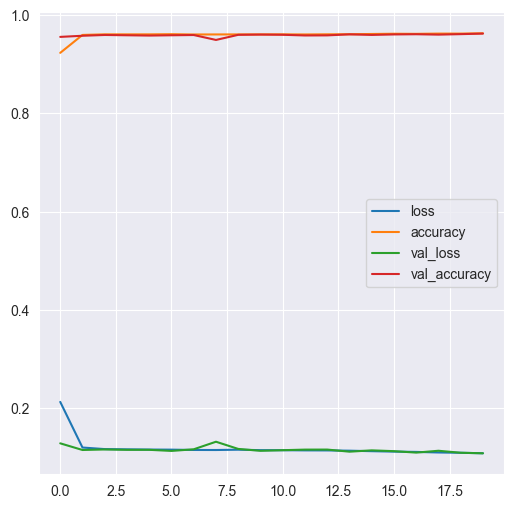

In [19]:
# Plot training history of model
d1=pd.DataFrame(hist.history)
d1.plot(figsize=(6,6))


In [20]:
# Define the Deep Neural Network with dropout
model2 = Sequential()
model2.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist2 = model2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1250/1250 [==============================] - 4s 2ms/step - loss: 0.2496 - accuracy: 0.9179 - val_loss: 0.1568 - val_accuracy: 0.9416
Epoch 2/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1531 - accuracy: 0.9446 - val_loss: 0.1253 - val_accuracy: 0.9568
Epoch 3/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1336 - accuracy: 0.9547 - val_loss: 0.1168 - val_accuracy: 0.9595
Epoch 4/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1258 - accuracy: 0.9577 - val_loss: 0.1119 - val_accuracy: 0.9598
Epoch 5/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1212 - accuracy: 0.9593 - val_loss: 0.1076 - val_accuracy: 0.9612
Epoch 6/20
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1184 - accuracy: 0.9605 - val_loss: 0.1105 - val_accuracy: 0.9622
Epoch 7/20
1250/1250 [==============================] - 2s 2ms/step - loss: 0.1160 - accuracy: 0.9614 - val_loss: 0.1052 - val_accuracy:

In [21]:
# Evaluate the model
y_pred2 = (model2.predict(X_test) > 0.5).astype('int32')
accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Model 2 Accuracy: {accuracy2}")


1563/1563 [==============================] - 2s 1ms/step
Model 2 Accuracy: 0.9672


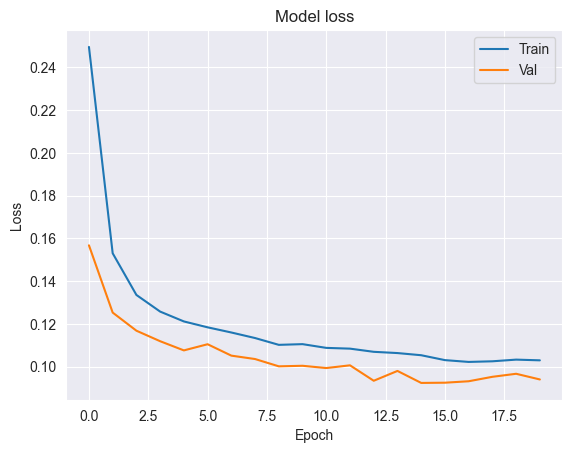

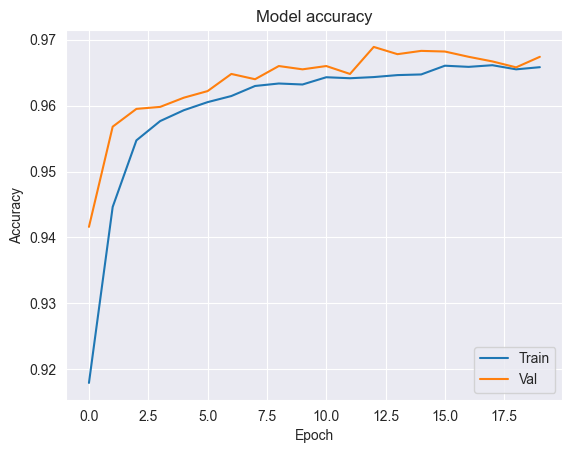

In [22]:
# Call the plot functions
plot_model_loss(hist2, 'Model loss')

plot_model_accuracy(hist2, 'Model accuracy')


In [23]:
# Print the summary
model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-traina

<AxesSubplot: >

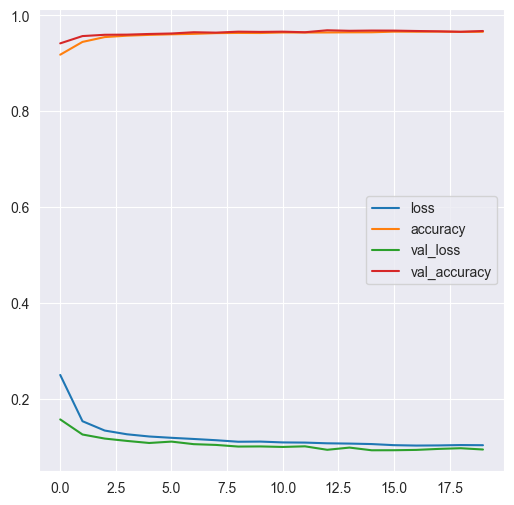

In [24]:
# Plot training history of model
d1=pd.DataFrame(hist2.history)
d1.plot(figsize=(6,6))


In [25]:
# Define the Keras Neural Network model
model3 = Sequential()
model3.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(16, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
hist3 = model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)


Epoch 1/50
625/625 [==============================] - 3s 2ms/step - loss: 0.1691 - accuracy: 0.9462 - val_loss: 0.1387 - val_accuracy: 0.9532
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.1182 - accuracy: 0.9593 - val_loss: 0.1211 - val_accuracy: 0.9583
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.1141 - accuracy: 0.9613 - val_loss: 0.1095 - val_accuracy: 0.9603
Epoch 4/50
625/625 [==============================] - 2s 3ms/step - loss: 0.1120 - accuracy: 0.9624 - val_loss: 0.1121 - val_accuracy: 0.9616
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.1092 - accuracy: 0.9638 - val_loss: 0.1165 - val_accuracy: 0.9612
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.1082 - accuracy: 0.9643 - val_loss: 0.1067 - val_accuracy: 0.9632
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.1060 - accuracy: 0.9652 - val_loss: 0.1043 - val_accuracy: 0.9635
Epoch 

In [26]:
# Evaluate the model
_, accuracy3 = model3.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy3:.4f}')


Test accuracy: 0.9701


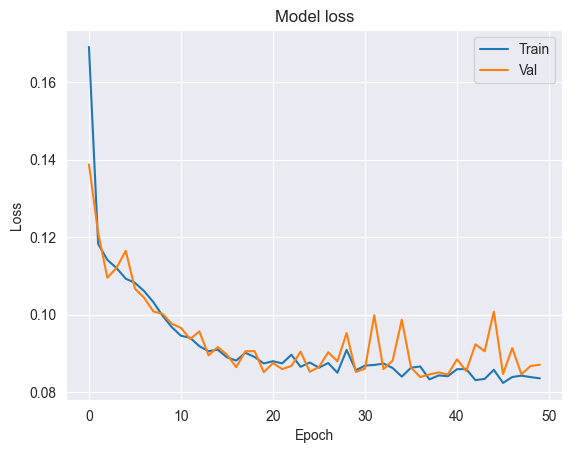

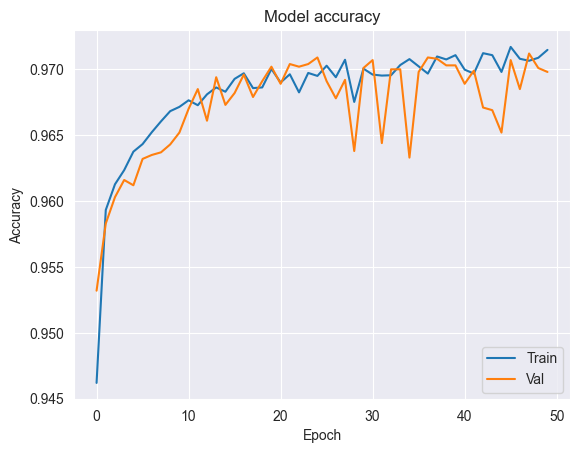

In [27]:
# Call the plot functions
plot_model_loss(hist3, 'Model loss')
plot_model_accuracy(hist3, 'Model accuracy')


In [28]:
# Print the summary
model3.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               1152      
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,033
Trainable params: 12,033
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot: >

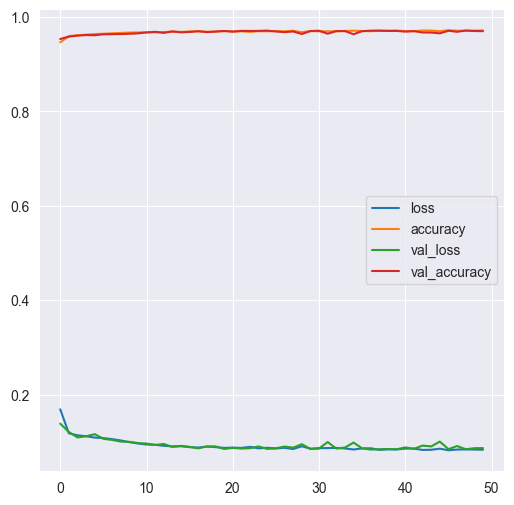

In [29]:
# Plot training history of model
d1=pd.DataFrame(hist3.history)
d1.plot(figsize=(6,6))


In [30]:
# Deep Neural Network Model - Multilayer Perception
batch_size = 512
data_tf_tr = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_tr_batches = data_tf_tr.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

data_tf_tre_eval = tf.data.Dataset.from_tensor_slices((X_test, y_test))
data_tre_batches_eval = data_tf_tre_eval.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
data_tf_tre = tf.data.Dataset.from_tensor_slices(X_test)
data_tre_batches = data_tf_tre.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Model fitting
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

e = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)
n = 8
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))
model.add(Dense(n * X_train.shape[1], activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy',
                       tf.keras.metrics.AUC(name='auc_precision_recall',
                                            curve='PR',
                                            num_thresholds=10000)])

hist4 = model.fit(data_tr_batches, epochs=50, callbacks=[e], validation_data=data_tr_batches, verbose=1)


Epoch 1/50
98/98 [==============================] - 3s 9ms/step - loss: 0.3130 - accuracy: 0.9070 - auc_precision_recall: 0.1276 - val_loss: 0.1593 - val_accuracy: 0.9477 - val_auc_precision_recall: 0.7352
Epoch 2/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1292 - accuracy: 0.9559 - auc_precision_recall: 0.7740 - val_loss: 0.1153 - val_accuracy: 0.9611 - val_auc_precision_recall: 0.8111
Epoch 3/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1150 - accuracy: 0.9604 - auc_precision_recall: 0.8092 - val_loss: 0.1118 - val_accuracy: 0.9618 - val_auc_precision_recall: 0.8191
Epoch 4/50
98/98 [==============================] - 0s 5ms/step - loss: 0.1130 - accuracy: 0.9611 - auc_precision_recall: 0.8145 - val_loss: 0.1110 - val_accuracy: 0.9618 - val_auc_precision_recall: 0.8223
Epoch 5/50
98/98 [==============================] - 0s 4ms/step - loss: 0.1118 - accuracy: 0.9616 - auc_precision_recall: 0.8177 - val_loss: 0.1106 - val_accuracy: 0.9620 - val

In [31]:
# Evaluate the model
loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test AUC: {test_auc:.4f}')


Test accuracy: 0.9709
Test AUC: 0.8778


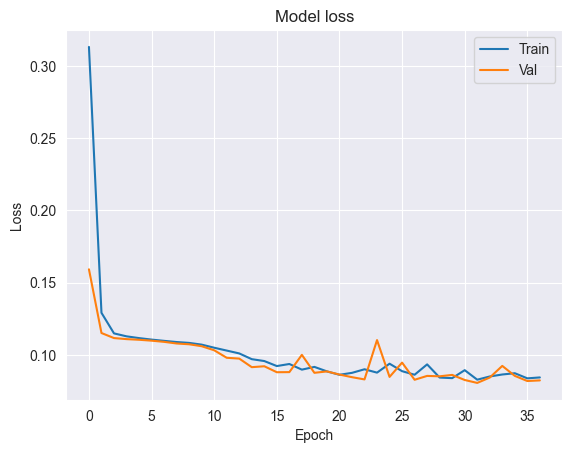

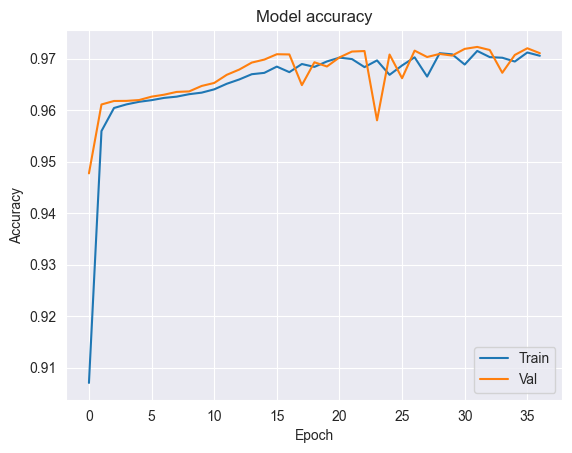

In [32]:
# Call the plot functions
plot_model_loss(hist4, 'Model loss')
plot_model_accuracy(hist4, 'Model accuracy')


In [33]:
# Print the summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                576       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)               

<AxesSubplot: >

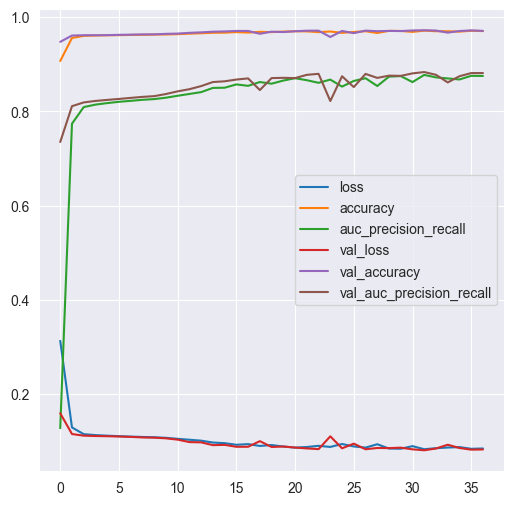

In [34]:
# Plot training history of model
d1=pd.DataFrame(hist4.history)
d1.plot(figsize=(6,6))


In [35]:
# Classification report for model evaluation
pred1 = (model.predict(data_tre_batches) > 0.5).astype(int)

from sklearn.metrics import classification_report

print(classification_report(pred1, y_test))


98/98 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     47098
           1       0.67      0.98      0.80      2902

    accuracy                           0.97     50000
   macro avg       0.83      0.98      0.89     50000
weighted avg       0.98      0.97      0.97     50000



In [36]:
# Accuracy scores dictionary
accuracy_scores = {
    'Neural Network Model': accuracy1,
    'Deep Neural Network model with dropout': accuracy2,
    'Keras Neural Network model': accuracy3,    
    'Deep Neural Network Model - Multilayer Perception': test_accuracy
}

# Find the model with the highest accuracy
best_model = max(accuracy_scores, key=accuracy_scores.get)
best_model_accuracy = accuracy_scores[best_model]

# Compare the accuracy of all models
print("\nAccuracy comparison of all models:\n")
for model_name, accuracy in accuracy_scores.items():
    print(f"{model_name}: {accuracy:.4f}")

print(f"\nThe best model is {best_model} with an accuracy of {best_model_accuracy:.4f}")



Accuracy comparison of all models:

Neural Network Model: 0.9618
Deep Neural Network model with dropout: 0.9672
Keras Neural Network model: 0.9701
Deep Neural Network Model - Multilayer Perception: 0.9709

The best model is Deep Neural Network Model - Multilayer Perception with an accuracy of 0.9709


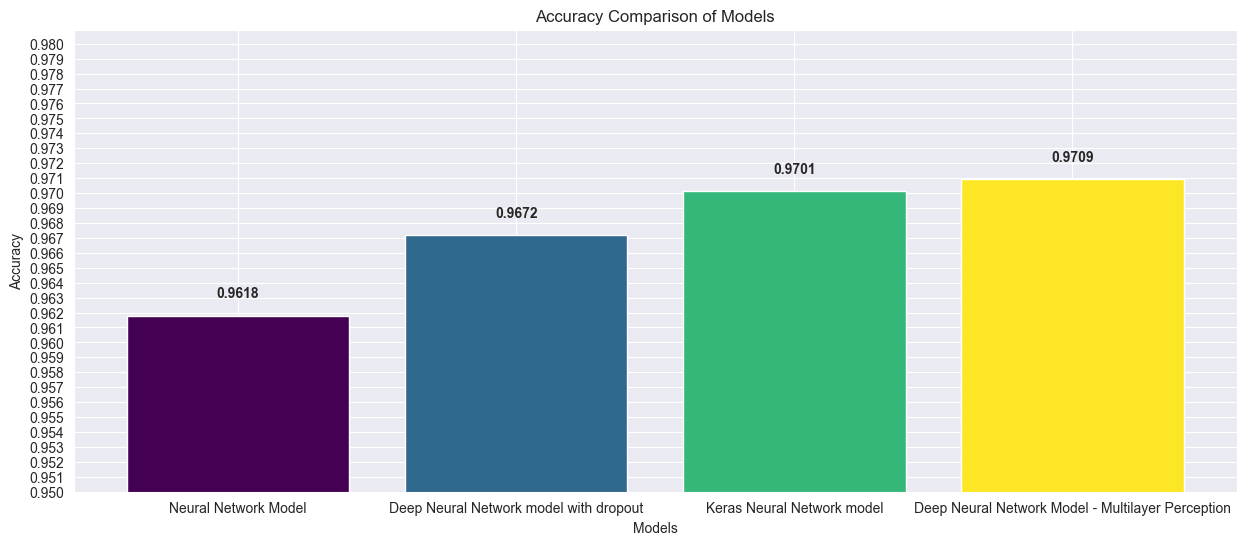

In [37]:
# Plot the accuracy of each model
plt.figure(figsize=(15, 6))
model_names = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())
colors = plt.cm.get_cmap('viridis', len(model_names))

bars = plt.bar(model_names, accuracies, color=colors(np.arange(len(model_names))))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')

plt.ylim(0.95, max(accuracies) + 0.01)
plt.yticks(np.arange(0.95, max(accuracies) + 0.01, 0.001))

# Display the accuracy value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width() / 2, height + 0.001, f"{height:.4f}",
                   ha='center', va='bottom', fontweight='bold')

plt.show()


In [38]:
# Top 10 combinations with the highest probabilities of getting diabetes - Values

age_groups = np.arange(20, 90, 10)
sexes = [0, 1]  # 0: Female, 1: Male
smoking_habits = [0, 1]  # 0: Non-smoker, 1: Smoker

combinations = [(age, sex, smoke) for age in age_groups for sex in sexes for smoke in smoking_habits]

mean_feature_values = np.mean(X_train, axis=0)

updated_combinations = [(age / 100, sex, smoke, *mean_feature_values[3:]) for age, sex, smoke in combinations]

probabilities = logistic_classifier.predict_proba(updated_combinations)[:, 1]

results = list(zip(combinations, probabilities))

sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

print("Top 10 combinations with the highest probabilities of getting diabetes:")
for i, (combination, probability) in enumerate(sorted_results[:10]):
    age, sex, smoke = combination
    sex_str = "Female" if sex == 0 else "Male"
    smoke_str = "Non-smoker" if smoke == 0 else "Smoker"
    print(f"{i + 1}. Age: {age}, Sex: {sex_str}, Smoking Habits: {smoke_str} - Probability: {probability:.4f}")
    

Top 10 combinations with the highest probabilities of getting diabetes:
1. Age: 80, Sex: Male, Smoking Habits: Smoker - Probability: 0.0730
2. Age: 70, Sex: Male, Smoking Habits: Smoker - Probability: 0.0712
3. Age: 60, Sex: Male, Smoking Habits: Smoker - Probability: 0.0695
4. Age: 50, Sex: Male, Smoking Habits: Smoker - Probability: 0.0678
5. Age: 40, Sex: Male, Smoking Habits: Smoker - Probability: 0.0662
6. Age: 30, Sex: Male, Smoking Habits: Smoker - Probability: 0.0646
7. Age: 20, Sex: Male, Smoking Habits: Smoker - Probability: 0.0630
8. Age: 80, Sex: Male, Smoking Habits: Non-smoker - Probability: 0.0354
9. Age: 70, Sex: Male, Smoking Habits: Non-smoker - Probability: 0.0345
10. Age: 60, Sex: Male, Smoking Habits: Non-smoker - Probability: 0.0337


C:\Users\sivak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


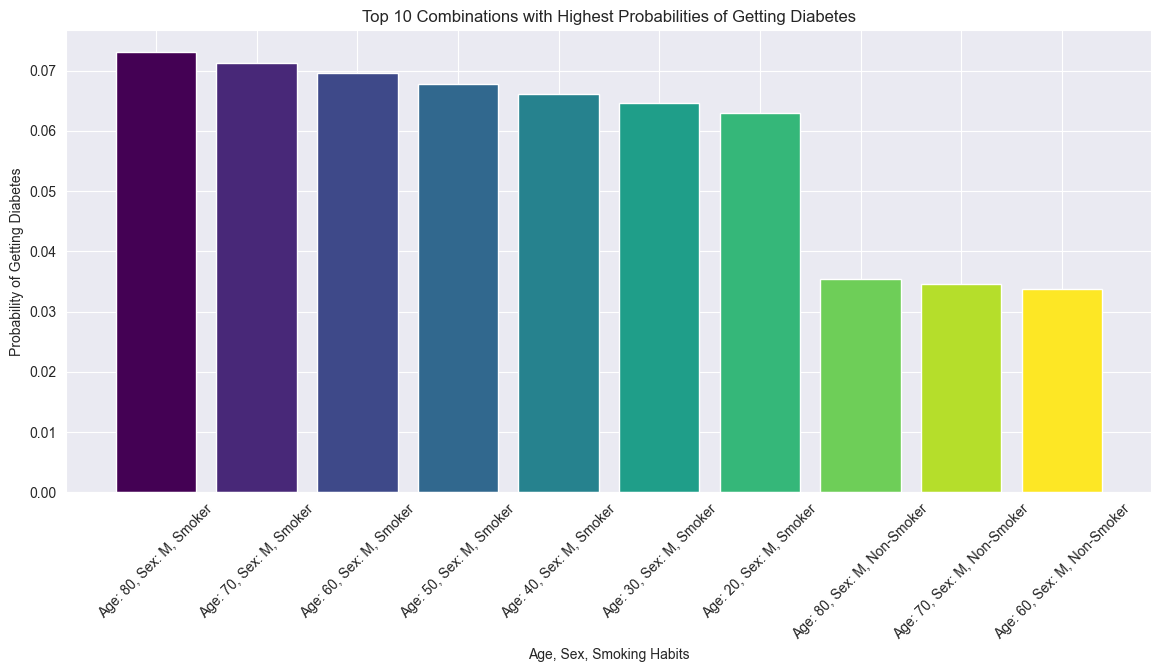

In [39]:
# Top 10 combinations with the highest probabilities of getting diabetes - Graph

# Combine combinations with their probabilities and sort them by probability
combinations_with_probabilities = list(zip(updated_combinations, probabilities))
combinations_with_probabilities.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 combinations with the highest probabilities
top_10_combinations = combinations_with_probabilities[:10]

# Separate the combinations and probabilities into separate lists
top_10_combinations_values, top_10_probabilities = zip(*top_10_combinations)

# Create the x-axis labels
x_labels = [f"Age: {int(age * 100)}, Sex: {'M' if sex == 1 else 'F'}, {'Smoker' if smoke == 1 else 'Non-Smoker'}" for age, sex, smoke, *_ in top_10_combinations_values]

# Plot the bar graph with different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_combinations_values)))
plt.figure(figsize=(14, 6))
plt.bar(x_labels, top_10_probabilities, color=colors)
plt.xticks(rotation=45)
plt.xlabel("Age, Sex, Smoking Habits")
plt.ylabel("Probability of Getting Diabetes")
plt.title("Top 10 Combinations with Highest Probabilities of Getting Diabetes")
plt.show()
